In [3]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import os
from skimage.measure import label
import pandas as pd
import seaborn as sns
import imageio
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay

In [4]:
def load_images(input_path, output_path_g, output_path_r):
    input_folder = input_path  
    output_folder_g = output_path_g
    output_folder_r = output_path_r

    for filename in os.listdir(input_folder):
        if filename.lower().endswith('.jpg'):
            img_path = os.path.join(input_folder, filename)
            img = cv.imread(img_path)       # loads in BGR format
            img = cv.resize(img, (256, 256))
            
            # convert to RGB format
            img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)     
            
            # convert to grayscale
            img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
            
            # using median blur (great for salt-n-pepper noise) with kernel size 5
            img_blur_g = cv.medianBlur(img_gray, 5)
            img_blur_r = cv.medianBlur(img_rgb, 5)
            
            # doing equalised histogram for contrast enhancement
            img_eq_g = cv.equalizeHist(img_blur_g)
            
            output_path = os.path.join(output_folder_g, filename)
            cv.imwrite(output_path, img_eq_g)
            output_path = os.path.join(output_folder_r, filename)
            cv.imwrite(output_path, img_blur_r)

            print(f"Processed and saved: {filename}")


#load_images("E:\\6th Semester\\DIP\\Assignment 2\\A2_wbc_data\\wbc_data\\Train\\Neutrophil", "E:\\6th Semester\\DIP\\Assignment 2\\A2_wbc_data\\wbc_data\\outputGray\\Neutrophil", "E:\\6th Semester\\DIP\\Assignment 2\\A2_wbc_data\\wbc_data\\outputRGB\\Neutrophil")
#load_images("E:\\6th Semester\\DIP\\Assignment 2\\A2_wbc_data\\wbc_data\\Train\\Monocyte", "E:\\6th Semester\\DIP\\Assignment 2\\A2_wbc_data\\wbc_data\\outputGray\\Monocyte", "E:\\6th Semester\\DIP\\Assignment 2\\A2_wbc_data\\wbc_data\\outputRGB\\Monocyte")
#load_images("E:\\6th Semester\\DIP\\Assignment 2\\A2_wbc_data\\wbc_data\\Train\\Lymphocyte", "E:\\6th Semester\\DIP\\Assignment 2\\A2_wbc_data\\wbc_data\\outputGray\\Lymphocyte", "E:\\6th Semester\\DIP\\Assignment 2\\A2_wbc_data\\wbc_data\\outputRGB\\Lymphocyte")
#load_images("E:\\6th Semester\\DIP\\Assignment 2\\A2_wbc_data\\wbc_data\\Train\\Eosinophil", "E:\\6th Semester\\DIP\\Assignment 2\\A2_wbc_data\\wbc_data\\outputGray\\Eosinophil", "E:\\6th Semester\\DIP\\Assignment 2\\A2_wbc_data\\wbc_data\\outputRGB\\Eosinophil")
#load_images("E:\\6th Semester\\DIP\\Assignment 2\\A2_wbc_data\\wbc_data\\Train\\Basophil", "E:\\6th Semester\\DIP\\Assignment 2\\A2_wbc_data\\wbc_data\\outputGray\\Basophil", "E:\\6th Semester\\DIP\\Assignment 2\\A2_wbc_data\\wbc_data\\outputRGB\\Basophil")

In [5]:
def kmeans_segmentation(image, k=8):
    # Reshape image to a 2D array of pixels
    pixel_values = image.reshape((-1, 3))
    pixel_values = np.float32(pixel_values)

    # Apply K-means clustering
    _, labels, centers = cv.kmeans(pixel_values, k, None,
                                    criteria=(cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 100, 0.2),
                                    attempts=10, flags=cv.KMEANS_RANDOM_CENTERS)
    labels = labels.flatten()
    segmented_image = centers[labels].reshape(image.shape).astype(np.uint8)
    return segmented_image, labels.reshape(image.shape[:2])


def extract_nucleus(image, label_map):
    unique_labels = np.unique(label_map)
    mean_intensity = [np.mean(image[label_map == label]) for label in unique_labels]
    nucleus_label = unique_labels[np.argmin(mean_intensity)]
    nucleus_mask = (label_map == nucleus_label).astype(np.uint8)
    return nucleus_mask


def clean_nucleus(nucleus_mask):
    labeled, num = label(nucleus_mask, return_num=True)
    if num == 0:
        return np.zeros_like(nucleus_mask)
    sizes = [(labeled == i).sum() for i in range(1, num + 1)]
    largest_label = np.argmax(sizes) + 1
    return (labeled == largest_label).astype(np.uint8)


def extract_features(image, nucleus_mask):
    # Compute area ratio
    nucleus_area = np.sum(nucleus_mask)
    total_area = image.shape[0] * image.shape[1]
    area_ratio = nucleus_area / total_area

    # Compute circularity
    contours, _ = cv.findContours(nucleus_mask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    if contours:
        largest_contour = max(contours, key=cv.contourArea)
        perimeter = cv.arcLength(largest_contour, True)
        circularity = (4 * np.pi * cv.contourArea(largest_contour)) / (perimeter ** 2 + 1e-5)
    else:
        circularity = 0

    # Compute mean and standard deviation of RGB values
    mask = nucleus_mask.astype(bool)
    pixels = image[mask]
    mean_rgb = np.mean(pixels, axis=0) if pixels.size > 0 else [0, 0, 0]
    std_rgb = np.std(pixels, axis=0) if pixels.size > 0 else [0, 0, 0]

    granularity = np.var(image[mask]) if pixels.size > 0 else 0
    red_green_ratio = mean_rgb[0] / (mean_rgb[1] + 1e-5)

    return {
        "area_ratio": area_ratio,
        "circularity": circularity,
        "mean_r": mean_rgb[0],
        "mean_g": mean_rgb[1],
        "mean_b": mean_rgb[2],
        "granularity": granularity,
        "red_green_ratio": red_green_ratio
    }
    

def process_images_and_save_csv(image_dir, output_csv, k=8):
    data = []

    for cell_type in os.listdir(image_dir):
        cell_dir = os.path.join(image_dir, cell_type)
        if not os.path.isdir(cell_dir):
            continue
        for file in os.listdir(cell_dir):
            image_path = os.path.join(cell_dir, file)
            image = cv.imread(image_path)
            if image is None:
                print(f"Failed to load image: {file}")
                continue

            # Step 1: K-means segmentation
            segmented_image, label_map = kmeans_segmentation(image, k=8)

            # Step 2: Extract nucleus
            nucleus_mask = extract_nucleus(segmented_image, label_map)

            # Step 3: Clean nucleus
            cleaned_mask = clean_nucleus(nucleus_mask)

            # Step 4: Extract features
            features = extract_features(image, cleaned_mask)
            features["label"] = cell_type
            features["filename"] = file  # Add filename to keep track

            data.append(features)

    # Step 5: Save to CSV
    df = pd.DataFrame(data)
    df.to_csv(output_csv, index=False)
    print(f"Features saved to: {output_csv}")


#process_images_and_save_csv("E:\\6th Semester\\DIP\\Assignment 2\\A2_wbc_data\\wbc_data\\outputRGB", "E:\\6th Semester\\DIP\\Assignment 2\\A2_wbc_data\\wbc_data\\outputCSV\\output_features.csv")

In [6]:
def plot_feature_vs_label(df, features):
    sns.set(style="whitegrid")
    num_features = len(features)
    
    plt.figure(figsize=(6 * num_features, 5))
    
    for i, feature in enumerate(features, 1):
        plt.subplot(1, num_features, i)
        sns.boxplot(x="label", y=feature, data=df, palette="Set2")
        plt.title(f"{feature} vs WBC Type")
        plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()

#df = pd.read_csv("E:\\6th Semester\\DIP\\Assignment 2\\A2_wbc_data\\wbc_data\\outputCSV\\output_features.csv")
#plot_feature_vs_label(df, ["area_ratio", "circularity", "mean_r", "granularity", "red_green_ratio"])


In [7]:
def classify_wbc(circularity, area_ratio, mean_r, granularity, red_green_ratio):
    # Reference ranges based on visual boxplot analysis
    wbc_profiles = {
        "Lymphocyte": {
            "circularity": (0.6, 0.9),
            "area_ratio": (0.04, 0.07),
            "mean_r": (110, 130),
            "granularity": (1600, 2200),
            "red_green_ratio": (3.5, 6.0)
        },
        "Eosinophil": {
            "circularity": (0.45, 0.75),
            "area_ratio": (0.03, 0.06),
            "mean_r": (120, 150),
            "granularity": (2000, 3000),
            "red_green_ratio": (4.0, 6.5)
        },
        "Monocyte": {
            "circularity": (0.3, 0.6),
            "area_ratio": (0.06, 0.09),
            "mean_r": (130, 160),
            "granularity": (1600, 2500),
            "red_green_ratio": (3.0, 6.0)
        },
        "Basophil": {
            "circularity": (0.1, 0.35),
            "area_ratio": (0.08, 0.12),
            "mean_r": (85, 115),
            "granularity": (1000, 1900),
            "red_green_ratio": (1.5, 3.5)
        },
        "Neutrophil": {
            "circularity": (0.35, 0.6),
            "area_ratio": (0.03, 0.06),
            "mean_r": (95, 125),
            "granularity": (1400, 2200),
            "red_green_ratio": (4.5, 7.0)
        }
    }


    def feature_diff(value, range_tuple):
        low, high = range_tuple
        if low <= value <= high:
            return 0
        elif value < low:
            return (low - value) / (high - low)
        else:
            return (value - high) / (high - low)

    features = {
        "circularity": circularity,
        "area_ratio": area_ratio,
        "mean_r": mean_r,
        "granularity": granularity,
        "red_green_ratio": red_green_ratio
    }

    min_score = float('inf')
    predicted_label = None

    for label, profile in wbc_profiles.items():
        score = sum(
            feature_diff(features[feature], profile[feature])
            for feature in features
        )
        if score < min_score:
            min_score = score
            predicted_label = label

    return predicted_label



    

def classify_from_csv(csv_path, output_path=None):
    df = pd.read_csv(csv_path)

    # Check if the necessary features are present
    required_cols = ["filename", "area_ratio", "circularity", "mean_r", "granularity", "red_green_ratio"]
    if not all(col in df.columns for col in required_cols):
        raise ValueError(f"CSV file must contain the following columns: {', '.join(required_cols)}")

    # Apply classification row by row
    df["predicted_label"] = df.apply(lambda row: classify_wbc(
        row["circularity"],
        row["area_ratio"],
        row["mean_r"],
        row["granularity"],
        row["red_green_ratio"]
    ), axis=1)

    # Save the results if an output path is provided
    if output_path:
        df.to_csv(output_path, index=False)
        print(f"Classification results saved to: {output_path}")

    return df

#csv_input = "E:\\6th Semester\\DIP\\Assignment 2\\A2_wbc_data\\wbc_data\\outputCSV\\output_features.csv"
#csv_output = "E:\\6th Semester\\DIP\\Assignment 2\\A2_wbc_data\\wbc_data\\outputCSV\\classification_results.csv"
#classified_df = classify_from_csv(csv_input, csv_output)

In [8]:
def evaluate_predictions(csv_path, actual_label_col="label", predicted_label_col="predicted_label"):
    df = pd.read_csv(csv_path)

    if actual_label_col not in df.columns or predicted_label_col not in df.columns:
        print(f"[ERROR] '{actual_label_col}' or '{predicted_label_col}' column not found in the CSV.")
        return

    y_true = df[actual_label_col]
    y_pred = df[predicted_label_col]

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    acc = accuracy_score(y_true, y_pred)

    print(f"[INFO] Accuracy: {acc * 100:.2f}%")

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_true))
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()

#evaluate_predictions("E:\\6th Semester\\DIP\\Assignment 2\\A2_wbc_data\\wbc_data\\outputCSV\\classification_results.csv")


In [50]:
import pandas as pd

# Load your classification results
df = pd.read_csv("E:\\6th Semester\\DIP\\Assignment 2\\A2_wbc_data\\wbc_data\\outputCSV\\classification_results.csv")

# Create a confusion matrix grouped by true label
grouped = df.groupby('label')

# Calculate per class accuracy
per_class_accuracy = {}
for label, group in grouped:
    correct = (group['label'] == group['predicted_label']).sum()
    total = len(group)
    accuracy = correct / total
    per_class_accuracy[label] = round(accuracy, 4)

# Convert to DataFrame
accuracy_df = pd.DataFrame.from_dict(per_class_accuracy, orient='index', columns=['Accuracy'])

# Calculate average per-class accuracy (macro avg)
average_accuracy = accuracy_df['Accuracy'].mean()
accuracy_df.loc['Average'] = average_accuracy

# Save or print
print(accuracy_df)

            Accuracy
Basophil       0.790
Eosinophil     0.540
Lymphocyte     0.360
Monocyte       0.480
Neutrophil     0.850
Average        0.604


[INFO] Accuracy: 67.20%


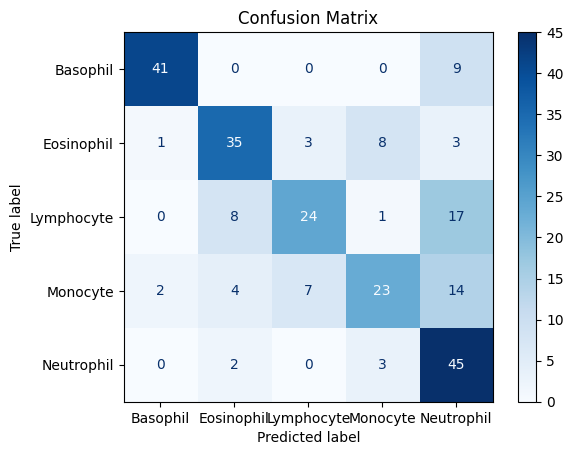

            Accuracy
Basophil       0.820
Eosinophil     0.700
Lymphocyte     0.480
Monocyte       0.460
Neutrophil     0.900
Average        0.672


In [10]:
def test_csv():
    #load_images("E:\\6th Semester\\DIP\\Assignment 2\\A2_wbc_data\\wbc_data\\Test\\Basophil", "E:\\6th Semester\\DIP\\Assignment 2\\A2_wbc_data\\wbc_data\\oTg\\Basophil", "E:\\6th Semester\\DIP\\Assignment 2\\A2_wbc_data\\wbc_data\\oTr\\Basophil")
    #load_images("E:\\6th Semester\\DIP\\Assignment 2\\A2_wbc_data\\wbc_data\\Test\\Neutrophil", "E:\\6th Semester\\DIP\\Assignment 2\\A2_wbc_data\\wbc_data\\oTg\\Neutrophil", "E:\\6th Semester\\DIP\\Assignment 2\\A2_wbc_data\\wbc_data\\oTr\\Neutrophil")
    #load_images("E:\\6th Semester\\DIP\\Assignment 2\\A2_wbc_data\\wbc_data\\Test\\Eosinophil", "E:\\6th Semester\\DIP\\Assignment 2\\A2_wbc_data\\wbc_data\\oTg\\Eosinophil", "E:\\6th Semester\\DIP\\Assignment 2\\A2_wbc_data\\wbc_data\\oTr\\Eosinophil")
    #load_images("E:\\6th Semester\\DIP\\Assignment 2\\A2_wbc_data\\wbc_data\\Test\\Lymphocyte", "E:\\6th Semester\\DIP\\Assignment 2\\A2_wbc_data\\wbc_data\\oTg\\Lymphocyte", "E:\\6th Semester\\DIP\\Assignment 2\\A2_wbc_data\\wbc_data\\oTr\\Lymphocyte")
    #load_images("E:\\6th Semester\\DIP\\Assignment 2\\A2_wbc_data\\wbc_data\\Test\\Monocyte", "E:\\6th Semester\\DIP\\Assignment 2\\A2_wbc_data\\wbc_data\\oTg\\Monocyte", "E:\\6th Semester\\DIP\\Assignment 2\\A2_wbc_data\\wbc_data\\oTr\\Monocyte")
    
    #process_images_and_save_csv("E:\\6th Semester\\DIP\\Assignment 2\\A2_wbc_data\\wbc_data\\oTr", "E:\\6th Semester\\DIP\\Assignment 2\\A2_wbc_data\\wbc_data\\outputCSV\\output_features_test.csv")
    
    #csv_input = "E:\\6th Semester\\DIP\\Assignment 2\\A2_wbc_data\\wbc_data\\outputCSV\\output_features_test.csv"
    #csv_output = "E:\\6th Semester\\DIP\\Assignment 2\\A2_wbc_data\\wbc_data\\outputCSV\\classification_results_test.csv"
    #df = classify_from_csv(csv_input, csv_output)
    
    evaluate_predictions("E:\\6th Semester\\DIP\\Assignment 2\\A2_wbc_data\\wbc_data\\outputCSV\\classification_results_test.csv")
    
    # Create a confusion matrix grouped by true label
    df = pd.read_csv("E:\\6th Semester\\DIP\\Assignment 2\\A2_wbc_data\\wbc_data\\outputCSV\\classification_results_test.csv")
    grouped = df.groupby('label')

    # Calculate per class accuracy
    per_class_accuracy = {}
    for label, group in grouped:
        correct = (group['label'] == group['predicted_label']).sum()
        total = len(group)
        accuracy = correct / total
        per_class_accuracy[label] = round(accuracy, 4)

    # Convert to DataFrame
    accuracy_df = pd.DataFrame.from_dict(per_class_accuracy, orient='index', columns=['Accuracy'])

    # Calculate average per-class accuracy (macro avg)
    average_accuracy = accuracy_df['Accuracy'].mean()
    accuracy_df.loc['Average'] = average_accuracy

    # Save or print
    print(accuracy_df)
    
test_csv()

In [18]:
def apply_padding(image, kernel_size, pad_value):
    padding_size = kernel_size // 2
    return cv.copyMakeBorder(image, padding_size, padding_size, padding_size, padding_size, cv.BORDER_CONSTANT, value=pad_value)

def rotated_lbp(img):
    weights = np.array([1, 2, 4, 8, 16, 32, 64, 128])
    
    lbpFinal = np.zeros_like(img, dtype=np.uint8)
    
    kernel_size = 3
    rep = np.zeros((kernel_size, kernel_size), dtype=np.uint8)
    
    padded_img = apply_padding(img, kernel_size, 0)
    height, width = img.shape
    
    for i in range(height):
        for j in range(width):
            region = padded_img[i:i+kernel_size, j:j+kernel_size]
            center_pixel = region[1, 1]
            
            binary_values = (region >= center_pixel).astype(np.uint8)
            
            neighbor_pixels = np.zeros(8, dtype=np.uint8)
            ind1 = 0
            for m in range(3):
                for n in range(3):
                    if m == 1 and n == 1:
                        continue 
                    neighbor_pixels[ind1] = binary_values[m, n]
                    ind1 += 1
                    
            dif = np.abs(neighbor_pixels - center_pixel)
            D = np.argmax(dif)
            rotated = np.roll(binary_values, -D)
            
            ind = 0
            for k in range(3):
                for l in range(3):
                    if k == 1 and l == 1:
                        continue
                    rep[k, l] = rotated[k, l] * weights[ind]
                    ind += 1
                    
            lbpFinal[i, j] = np.sum(rep)
    
    return lbpFinal



def extract_features_lbp(input_path):
    data = []
    num_bins = 256  # Define number of bins beforehand

    for cell_type in os.listdir(input_path):
        class_path = os.path.join(input_path, cell_type)
        if not os.path.isdir(class_path):
            print("??", class_path)
            continue

        for img_file in os.listdir(class_path):
            img_path = os.path.join(class_path, img_file)
            img = cv.imread(img_path, cv.IMREAD_GRAYSCALE)

            if img is None:
                print("????", img_path)
                continue

            # Apply LBP
            lbp = rotated_lbp(img)

            # Compute histogram (feature vector)
            hist, _ = np.histogram(lbp.ravel(), bins=num_bins, range=(0, num_bins))
            
            # Normalize histogram
            hist = hist.astype("float")
            hist /= (hist.sum() + 1e-6)

            # Append to data
            feature_row = [img_file] + list(hist) + [cell_type]
            data.append(feature_row)
            print(f"{img_file} – Histogram sum: {hist.sum()}")

    if not data:
        print("No data extracted. Check your folder paths or image read logic.")
        return

    # Construct column names based on num_bins
    columns = ['filename'] + [f'lbp_{i}' for i in range(num_bins)] + ['label']
    
    df = pd.DataFrame(data, columns=columns)
    df.to_csv('E:\\6th Semester\\DIP\\Assignment 2\\A2_wbc_data\\wbc_data\\outputCSV\\lbp_features.csv', index=False)
    
extract_features_lbp("E:\\6th Semester\\DIP\\Assignment 2\\A2_wbc_data\\wbc_data\\outputGray")

Basophil_1.jpg – Histogram sum: 0.9999999999847413
Basophil_10.jpg – Histogram sum: 0.9999999999847413
Basophil_100.jpg – Histogram sum: 0.9999999999847413
Basophil_11.jpg – Histogram sum: 0.9999999999847413
Basophil_12.jpg – Histogram sum: 0.9999999999847414
Basophil_13.jpg – Histogram sum: 0.9999999999847413
Basophil_14.jpg – Histogram sum: 0.9999999999847413
Basophil_15.jpg – Histogram sum: 0.9999999999847413
Basophil_16.jpg – Histogram sum: 0.9999999999847413
Basophil_17.jpg – Histogram sum: 0.9999999999847413
Basophil_18.jpg – Histogram sum: 0.9999999999847413
Basophil_19.jpg – Histogram sum: 0.9999999999847413
Basophil_2.jpg – Histogram sum: 0.9999999999847411
Basophil_20.jpg – Histogram sum: 0.9999999999847413
Basophil_21.jpg – Histogram sum: 0.9999999999847413
Basophil_22.jpg – Histogram sum: 0.9999999999847415
Basophil_23.jpg – Histogram sum: 0.9999999999847413
Basophil_24.jpg – Histogram sum: 0.9999999999847412
Basophil_25.jpg – Histogram sum: 0.9999999999847415
Basophil_26.j

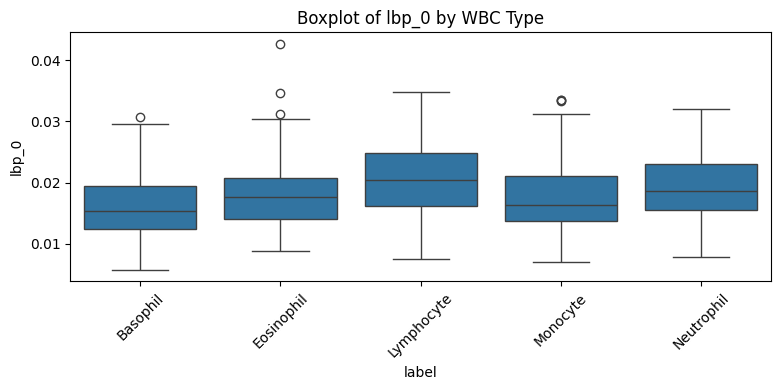

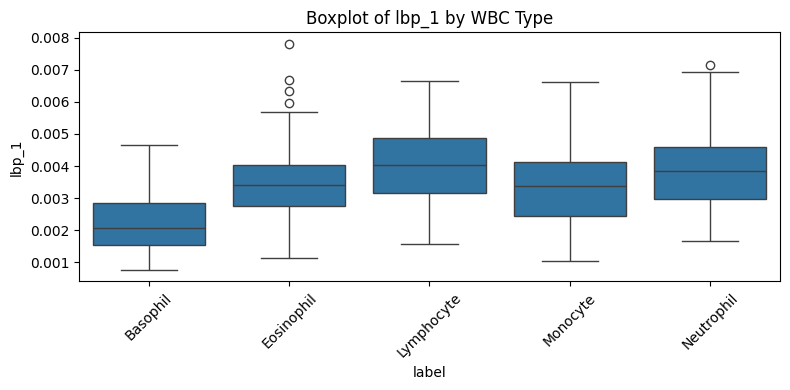

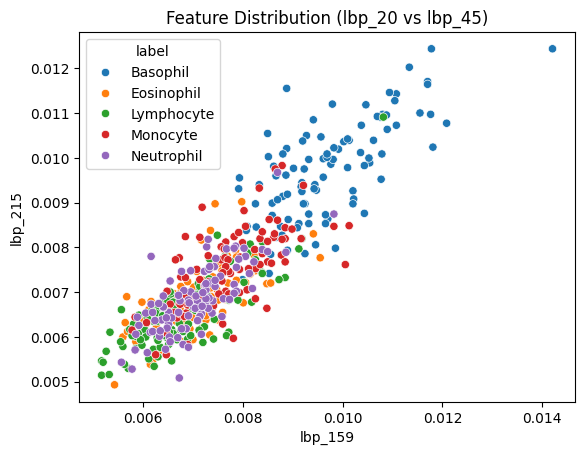

In [33]:
df = pd.read_csv('E:\\6th Semester\\DIP\\Assignment 2\\A2_wbc_data\\wbc_data\\outputCSV\\lbp_features.csv')

# Plot one feature across all cell types
for i in range(2):  # First 10 LBP bins
    plt.figure(figsize=(8, 4))
    sns.boxplot(x='label', y=f'lbp_{i}', data=df)
    plt.title(f'Boxplot of lbp_{i} by WBC Type')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Example: Scatter plot for two features
sns.scatterplot(data=df, x='lbp_159', y='lbp_215', hue='label')
plt.title("Feature Distribution (lbp_20 vs lbp_45)")
plt.show()